In [1]:
from config import *
import re
import json
from scipy.spatial import KDTree
from easyric import caas_lite
import tifffile as tf
from skimage.transform import ProjectiveTransform

from easyric.caas_lite import TiffSpliter
from easyric.objects import Pix4D
from easyric.io import shp, geotiff, plot
from easyric.calculate import geo2raw, geo2tiff

import os
import shapefile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shapely
import tifffile



In [2]:
p2 = Paths("0520_p")

p4d = Pix4D(project_path=p2.pix4d_project, 
            raw_img_path=p2.raw_img, 
            project_name=p2.project_name,
            param_folder=p2.pix4d_param)

shp_file = r"Y:\hwang_Pro\data\2020_tanashi_broccoli\02_GIS\rotate_grids\split_grid_2.5m.shp"

process_area = shp.read_shp2d(shp_file, geotiff_proj=p4d.dsm_header['proj'], name_field="id")
process_area.keys()

[Init][Pix4D] No ply given, however find 'broccoli_tanashi_5_20200520_P4M_10m_group1_densified_point_cloud.ply' at current project folder
[Init][Pix4D] No dom given, however find 'broccoli_tanashi_5_20200520_P4M_10m_transparent_mosaic_group1.tif' at current project folder
[Init][Pix4D] No dsm given, however find 'broccoli_tanashi_5_20200520_P4M_10m_dsm.tif' at current project folder
[io][geotiff][GeoCorrd] Comprehense [* 34737 geo_ascii_params (30s) b'WGS 84 / UTM zone 54N|WGS 84|'] to geotiff coordinate tag [WGS 84 / UTM zone 54N]
[io][geotiff][GeoCorrd] Comprehense [* 34737 geo_ascii_params (30s) b'WGS 84 / UTM zone 54N|WGS 84|'] to geotiff coordinate tag [WGS 84 / UTM zone 54N]
[io][shp][fields] Shp fields: {'id': 0, 'left': 1, 'top': 2, 'right': 3, 'bottom': 4}
[io][shp][proj] find ESRI projection file Y:\hwang_Pro\data\2020_tanashi_broccoli\02_GIS\rotate_grids\split_grid_2.5m.prj, and successfully obtain projection cartesian


dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157'

In [3]:
def read_json(json_path):
    container = []
    with open(json_path, "r", encoding="utf-8") as f:
        js = json.loads(f.read())
        for item in js["shapes"]:
            points = np.asarray(item["points"])
            points = np.append(points, points[0,:][None,:], axis=0)
            container.append(points)
    return container

def json_name(date, roi_id, file_name):
    return f"labeled_v0_{date}_{roi_id}_{file_name[:-4]}.json"

In [4]:
demo_path = r"Y:\hwang_Pro\data\2020_tanashi_broccoli\13_roi_on_raw\valid"
demo_json = ["DJI_0994.JPG", "DJI_0995.JPG", "DJI_0996.JPG"]

In [5]:
xh = np.arange(0, p4d.img[0].w)
yh = np.arange(0, p4d.img[0].h)
xv, yv = np.meshgrid(xh, yh)
xu = xv.reshape(-1)
yu = yv.reshape(-1)  # corrected idea
xc, yc = geo2raw.distortion_correction(p4d, xu, yu, 0)   # raw image

cor_table = np.vstack([xu, yu]).T
raw_table = np.vstack([xc, yc]).T

kdtree = KDTree(raw_table)

In [6]:
def mk_rm_line(bound_np, rm_bound_id):
    bound_np = bound_np[:-1, :]
    
    return shapely.geometry.LineString(bound_np[rm_bound_id-1:rm_bound_id+2,:])

def get_grid_roi_info(df_csv, id, image_name):
    filtered = df_csv[(df_csv.id == id) & (df_csv.image == image_name)]
    roi_str = filtered.roi.values[0]
    roi_str = roi_str.replace("\n ", ",")
    roi_str = re.sub("\s+", ",", roi_str)
    roi_np = np.asarray(eval(roi_str))
    off_x = filtered.offset_x.values[0]
    off_y = filtered.offset_y.values[0]
    
    return roi_np, off_x, off_y

In [7]:
def dis2undis(cor_table, tree, polygon):
    dist, index = tree.query(polygon)
        
    return cor_table[index, :]

In [8]:
def crop_by_coord(dom, coord_np, buffer=20):
    text_center = coord_np.mean(axis=0)
    xmin, ymin = coord_np.min(axis=0)
    xmax, ymax = coord_np.max(axis=0)
    
    j0 = xmin-buffer
    i0 = ymin-buffer
    w = xmax-xmin+buffer*2
    h = ymax-ymin+buffer*2
    
    ts = caas_lite.TiffSpliter(dom, 2000, 2000)
    tif = tf.TiffFile(ts.tif_path)
    
    cropped = ts.get_crop(tif.pages[0], i0, j0, h, w)
    
    offset = np.asarray([j0, i0])
    
    coord_np_off = coord_np - offset
    
    return cropped, coord_np_off, offset 

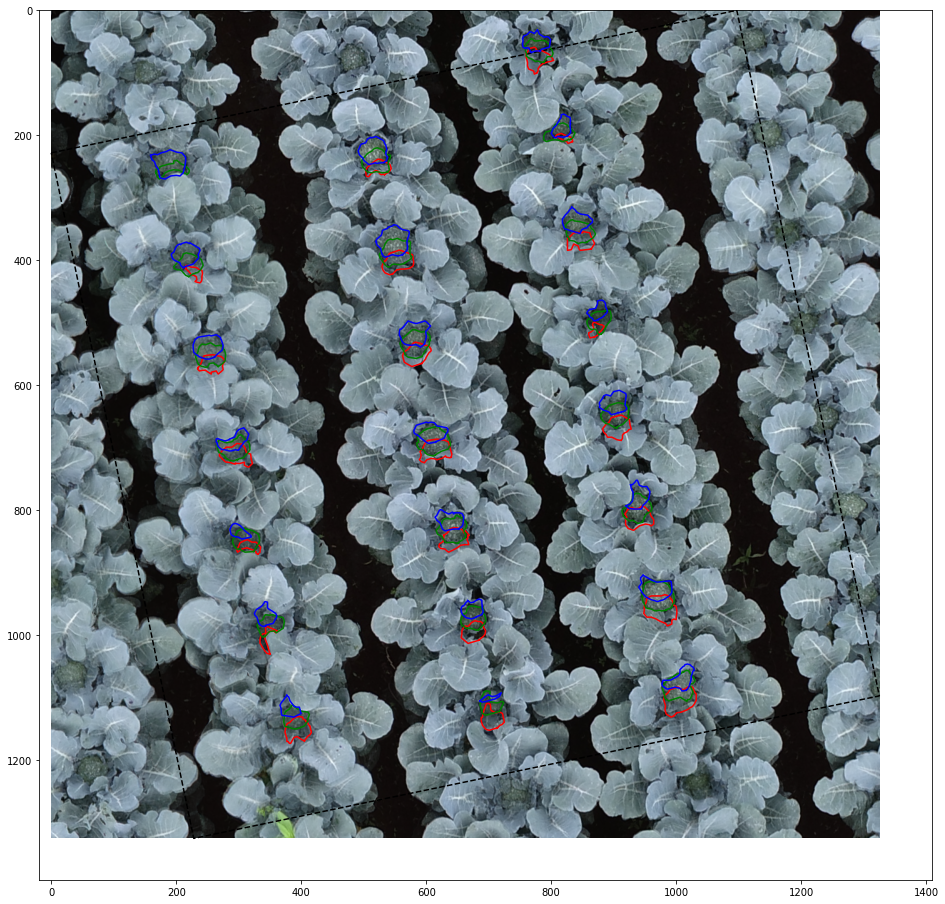

In [12]:
before_project = pd.read_csv(f"{p2.root}/13_roi_on_raw/{p2.project_name}.csv")

detected_merge_poly = []

# plot
color = ["r", "g", "b"]

## crop dom to small parts 
new_coord = geotiff.geo2pixel(process_area["66"], geo_head=p4d.dom_header)
cropped, np_off, offset = crop_by_coord(p4d.dom_file, new_coord, buffer=0)
plt.imshow(cropped)

new = new_coord - offset

plt.plot(*new.T, 'k--')

for k, img_n in enumerate(demo_json):
    #if k != 1:
    #    continue
        
    roi_np, off_x, off_y = get_grid_roi_info(before_project, 66, img_n)
    detect_poly = read_json(os.path.join(demo_path, json_name(20200520, 66, img_n)))
    
    # correct json offsets
    detect_poly_correct = []
    for roi in detect_poly:
        # correct by distortion
        roi_off = roi + np.asarray([off_x, off_y])
        roi_correct = dis2undis(cor_table, kdtree, roi_off)
        detect_poly_correct.append(roi_correct)
        
    # filter in broccolis
    grid_poly = shapely.geometry.Polygon(roi_np)
    rm_line = mk_rm_line(roi_np, 2)
    
    shapely_detect_in = []
    shapely_detect_out = []
    for i, roi in enumerate(detect_poly_correct):
        roi_spy = shapely.geometry.Polygon(roi)
        if roi_spy.intersects(rm_line):
            shapely_detect_out.append(i)
        else:
            if roi_spy.intersects(grid_poly):
                shapely_detect_in.append(i)
            else:
                shapely_detect_out.append(i)

    # reverse to dom coords
    pt = ProjectiveTransform()
    pt.estimate(process_area["66"] - p4d.offset.np[0:2], roi_np)
    for idx in shapely_detect_in:
        inv_np = pt.inverse(detect_poly_correct[idx])
        detected_merge_poly.append(inv_np)
    
        # plot
        inv_np_dom = geotiff.geo2pixel(inv_np + p4d.offset.np[0:2], geo_head=p4d.dom_header) - offset
        plt.plot(*inv_np_dom.T, f"{color[k]}-")
        
plt.gca().axis('equal')
plt.gcf().set_size_inches((16, 16))

In [21]:
offset

array([5372, 6686])